# Analyzing Play Time Contribution by Different Player Types

## Introduction

PLAI, an AI research group within the Faculty of Computer Science at UBC, has set up a Minecraft server to develop an AI that surpasses current technological constraints. Through this server, the researchers have gathered data on participants' in-game actions and communication, with the goal of collecting over 10,000 hours of data to create a complex AI that replicates player-like behaviour within the virtual world, or similarly, an AGI (Artificial General Intelligence)-like agent. However, to gather more significant data, PLAI researchers aim to identify which players, or player types, contribute the most hours of gameplay. Therefore, this analysis will address the following question: Can we determine which players are most likely to contribute the most hours of gameplay based on their age and experience with the game?

To answer the question, this project uses two datasets containing player information and session details: ```players.csv``` and ```sessions.csv```.

*[ ] indicates variable data type

---

```players.csv```: A dataset containing identifying information provided during recruitment for all participants, including their total playtime. It contains 196 **observations** and 9 **variables**.

- ```experience```: Participant's self-reported Minecraft experience level [Character/Categorical] - (Amateur, Beginner, Regular, Pro, Veteran).
- ```subscribe```: Whether the participant is subscribed to PLAI emails [Character].
- ```hashedEmail```: The participant's provided email address, encrypted for privacy [Character]. 
- ```played_hours```: Total number of hours the participant has played on the server [Double].
- ```name```: The participant's provided name [Character].
- ```gender```: The participant's identified gender [Character].
- ```age```: The participant's age [Double].
- ```IndividualID```: The participant's ID; another means of identification [Logical].*
- ```organizationName```: The participant's affiliated organization [Logical].*

*Note: **IndividualID** and **organizationName** are labelled as NA and are not provided in the dataset.

---


```sessions.csv```: A dataset containing each play session per individual, including their start and end times. It contains 1535 **observations** and 5 **variables**. 

- ```hashedEmail```: The participant's provided email address, encrypted for privacy [Character].
- ```start_time```: Session start date (dd/mm/yyyy) and time (24hr) [Character].
- ```end_time```: Session end date (dd/mm/yyyy) and time (24hr) [Character].
- ```original_start_time```: Session start time in UNIX timestamp - seconds since Jan 1st, 1970 (UTC) [Double].
- ```original_end_time```: Session end time in UNIX timestamp - seconds since Jan 1st, 1970 (UTC) [Double].

---

## Methods & Results

We will use **KNN-Classification** with `age` and `played_hours` as predictor variables, identifying the types of players that have the highest playtime. To address the question, we will use the categorical variable, `experience`, to classify players as **Amateurs**, **Beginners**, **Regulars**, **Pros**, or **Veterans**.

---
### Loading the packages into R

To begin the analysis, we loaded the following **packages**:
1. ```tidyverse``` - Contains most of the basic functions needed for analysis (ex. data wrangling)

2. ```RColorBrewer``` - Introduces additional color palettes for visualization, which is important for addressing colorblindness. 

3. ```tidymodels``` - Provides functions necessary to train and create the KNN-classification model. 

4. ```repr``` - Contains functions to control how R objects are displayed (ex. Reformatting visualizations)

5. ```themis``` - Includes the ```step_upsample``` function needed for balancing the ```experience``` class.

6. ```gridExtra``` - Illustrates plots side-by-side. 

Next, we use the ```options``` function with the ```matrix``` argument to limit the display of all data frames to **5 rows/observations**. 


In [39]:
#Contains most functions needed for analysis.
library(tidyverse) 

#To obtain colors for visualization: Colorblind-friendly Palettes
library(RColorBrewer) 

#Contains the functions to create a model.
library(tidymodels)

#Controls how R objects are displayed. Enhances the details of outputs by indirectly formatting how they appear (ex. options). 
library(repr)

#To balance the classes in the "experience" variable.
library(themis)

#To put plots side by side
library(gridExtra)

#To obtain a maximum of 5 rows per data frame.
options(repr.matrix.max.rows = 5) 


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### Reading the datasets into R

Next, we loaded both ```players.csv``` and ```sessions.csv``` into the analysis using the ```read_csv``` function and their respective URLs. 

The data frames were assigned to their respective names: ***players*** and ***sessions***.

In [5]:
#Loading both datasets (players and session data) into the datafile. 
players <- read_csv ("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

sessions <- read_csv ("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling
In this section, we wrangled the data into a tidy format, creating a data frame with the variables of interest: ```experience```, ```played_hours```, and ```age```.

1. The ```set.seed``` function was used with a value of 100 to ensure **reproducibility** for functions involving randomness.*

*This was done in every coding cell.

---
2. The ```merge``` function combined the **players** and **sessions** datasets based on matching ```hashedEmail``` values, treating separate instances (ex. different ```start_time``` and ```end_time```) as distinct observations. 

3. The merged dataset was further refined using the ```select``` function to contain only the variables of interest.

4. Rows with ```played_hours``` equal to 0 were removed using the ```filter``` function. These values are irrelevant to the analysis and problematic for visualization. The y-axis must be log-scaled to spread the points out, reducing overplotting. However, this would turn zeroes into infinities, which could mislead KNN classification by treating them as non-zero values.

5. The ```mutate``` function with ```as_factor``` was used to convert ```experience``` from a **character** data type to a **factor** (categorical) variable. 

6. Finally, the ```head``` and ```tail``` functions displayed the wrangled dataset's first and last 6 rows (**playdate_final**). 

In [8]:
#Setting the seed. (1)
set.seed (100)

#Wrangling the data - Begin by merging sessions.csv and players.csv together based on matching values of the hashedEmail variable. (2)
playdate <- merge (x = players, y = sessions, by = "hashedEmail", all = TRUE)

#Selecting the columns of interest (experience, played_hours, age). (3)
playdate_select <- playdate |>
select (experience, played_hours, age)

#Remove all values of "played_hours" that equal to 0. (4)
playdate_NA <- playdate_select |>
filter (played_hours > 0)

#Converting experience into a factor data type - categorical (5).
playdate_final <- playdate_NA |>
select (experience:age) |>
mutate (experience = as_factor(experience))

#Printing out the first and last 6 rows to see what we are working with. (6)
head(playdate_final, 6)
tail (playdate_final, 6)

,experience,played_hours,age
,<fct>,<dbl>,<dbl>
1,Regular,1.5,20
2,Regular,1.5,20
3,Pro,0.4,21
⋮,⋮,⋮,⋮
5,Regular,5.6,17
6,Regular,5.6,17


,experience,played_hours,age
,<fct>,<dbl>,<dbl>
1516,Amateur,56.1,23
1517,Amateur,56.1,23
1518,Amateur,56.1,23
⋮,⋮,⋮,⋮
1520,Amateur,0.1,17
1521,Beginner,1.1,20


### Exploring the Data // Visualization and Summary
In this section, we created a visualization to better understand the data. ```Age``` was placed on the x-axis as the independent variable and ```played_hours``` on the y-axis, as it might vary based on age. Data points were distinguished by color and shape based on the categorical variable, ```experience```. 

1. Using the ```options``` function with ```repr.plot.*```, we pre-set the plot's width and height.

2. A scatter plot was created to show the relationship between ```age``` and ```played_hours```, with points classified by ```experience``` using color and shape. An ```alpha``` value of **0.5** reduced overplotting issues, while the y-axis was logarithmically scaled to better distribute clustered values for easier interpretation. 


***Additional Notes:***
- A color-blind friendly palette was chosen using the ```display.color.brewer (colorblindFriendly = TRUE)``` function.
- The ```theme``` function was used to adjust the text size for readability. 

---
3. A **summary** of the dataset revealed a significant class imbalance, with **Regular** and **Amateur** classes dominating. This class imbalance can hinder K-NN classification by prioritizing predictions toward larger classes. To fix this, the ```step_upsample``` function will be used in model recipes to oversample smaller classes, reducing bias via balancing classes to a 1:1 ratio. 

experience,total
<fct>,<int>
Regular,516
Pro,39
Beginner,103
Veteran,50
Amateur,813


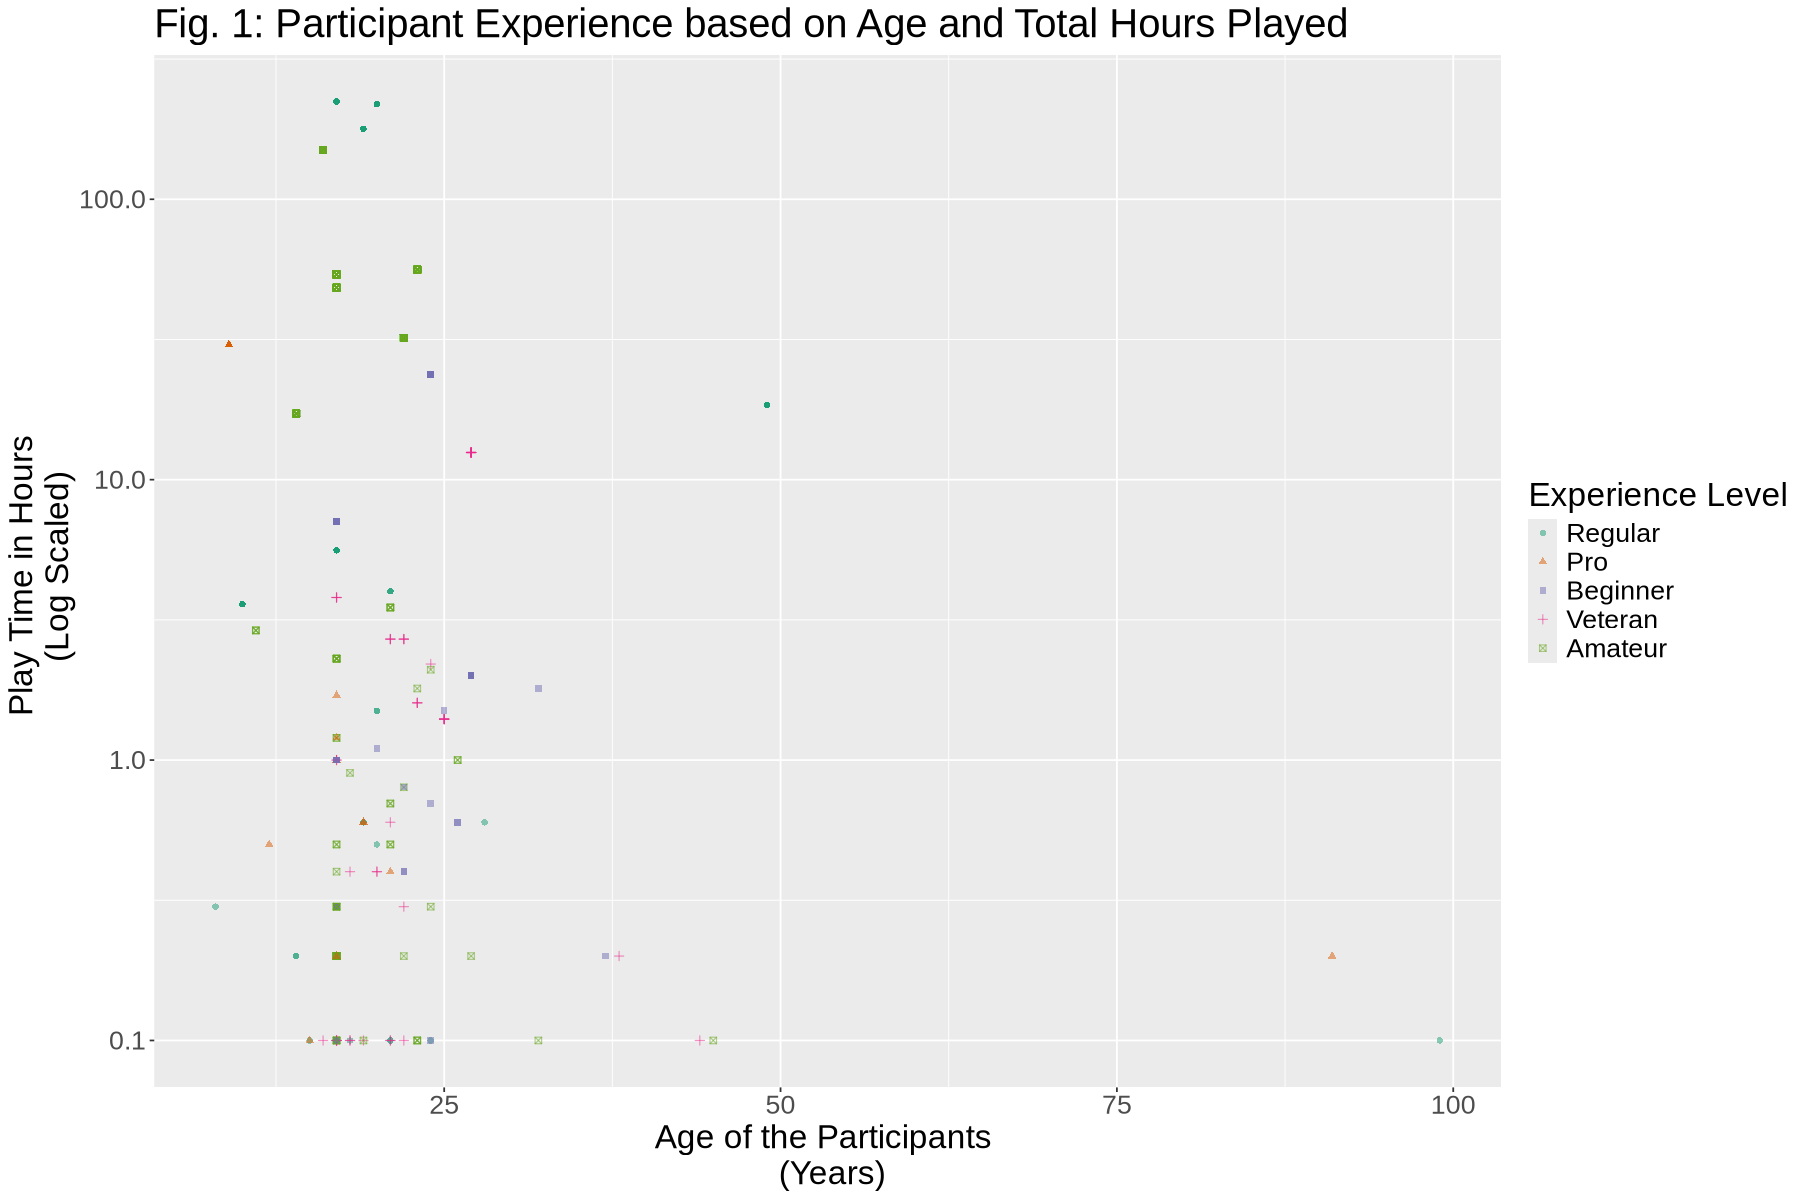

In [13]:
set.seed (100)

#Setting the initial plot size. (1)
options (repr.plot.width = 15, repr.plot.height = 10)

#Creating a visualization to see what we're working with; x = age as it is independent, y = played_hours as it might change based on age. (2)
playdate_vision <- playdate_final |>
ggplot (aes(x = age, y = played_hours, color = experience, shape = experience)) +
geom_point(alpha = 0.5) +
scale_color_brewer (palette = "Dark2") +
labs (x = "Age of the Participants \n (Years)", y = "Play Time in Hours \n (Log Scaled)", title = "Fig. 1: Participant Experience based on Age and Total Hours Played"
      , color = "Experience Level", shape = "Experience Level") +
theme (text = element_text (size = 20)) +
scale_y_log10 ()

#Creating the summary for total observations per class/category. (3)
playdate_summary <- playdate_final |>
group_by (experience) |>
summarise (total = n())

playdate_vision
playdate_summary

### Tuning the Model
This section focuses on model tuning. We will use 5-fold cross-validation to select the best K value and create the most accurate model using the selected predictor variables. 

1. First, using **playdate_final**, we split the dataset with the ```initial_split``` function, allocating 75% to the training set and 25% to the testing set. The ```strata``` argument was set to our categorical variable, ```experience``` maintaining equal proportions per class in each split.

2. We then obtained the training and testing sets with the ```training``` and ```testing``` functions, naming them **playdate_training** and **playdate_testing**. 

3.  Using the ```recipe``` function, we created a recipe to define the preprocessing steps for the data in the ```workflow``` function. Standardization is performed on the variables in the dataset specified by the **data** argument.

4. We built the KNN classifier using the ```nearest_neighbors``` function, setting ```weight_func``` to "rectangular" (one vote per neighbor) and set the ```neighbors``` argument to ```tune()``` to find the optimal K parameter with 5-fold cross-validation. The engine was set to "kknn", and the mode to "classification".

5. A **K-values** data frame called **play_k** was created using the ```tibble``` function to test K values from **1** to **100**, stepping by **2**. 

6. The training set was split into **validation** and **training** subsets with the ```vfold_cv``` function. The function divides the data into 5 evenly sized chunks, using one chunk as the **validation** set each time, with the remaining chunks as the **training** set. K-NN classification is performed for each K-value across the 5 folds, with the average accuracy calculated for each. This allows us to select the best **K parameter** based on the highest average accuracy. 

7. Finally, we used the ```workflow``` function to build and tune the model. We then used ```collect_metrics``` and ```filter``` to arrange the **accuracies** for each **K-value** in **descending** order.  

In [15]:
set.seed (100)

#Split the data into a training and testing set. (1)
playdate_split <- playdate_final |>
initial_split (prop = 0.75, strata = experience)

#Obtain the training and testing sets. (2) 
playdate_training <- training (playdate_split)
playdate_testing <- testing (playdate_split)

#Creating the recipe. (3)
playdate_recipe <- recipe (experience ~., data = playdate_training) |>
                    step_scale (all_predictors()) |>
                    step_center (all_predictors()) |>
                    step_upsample (experience, over_ratio = 1, skip = TRUE)
#Note: We set skip = TRUE to apply upsampling only to the training set and not the validation set for each instance of cross-validation. 


#Creating the tuning model. (4)
playdate_model_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |>
                        set_engine ("kknn") |>
                        set_mode ("classification")

#Creating the tibble of K values. (5)
play_k <- tibble (neighbors = seq (from = 1, to = 100, by = 2))

#Creating the validation data set (6)
playdate_vfold <- vfold_cv (playdate_training, v = 5, strata = experience)

#Creating the workflow and obtaining a data frame only containing the tested K-value accuracies. (7)
knn_tune_results <- workflow () |>
add_model (playdate_model_tune) |>
add_recipe (playdate_recipe) |>
tune_grid (resamples = playdate_vfold, grid = play_k) |>
collect_metrics () |>
filter (.metric == "accuracy") |>
arrange (desc(mean)) 

knn_tune_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9438626,5,0.002539993,Preprocessor1_Model01
3,accuracy,multiclass,0.9377106,5,0.002213546,Preprocessor1_Model02
5,accuracy,multiclass,0.9368373,5,0.002271259,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,accuracy,multiclass,0.8509174,5,0.02402749,Preprocessor1_Model50
97,accuracy,multiclass,0.8500441,5,0.02347594,Preprocessor1_Model49


From this, we see that **K = 1** achieves the highest **accuracy** when predicting classes (```experience```). However, we cannot select K = 1 as our parameter as it would lead to **overfitting**, causing the classifier to predict classes solely on the **closest neighbor**. This is undesirable, as changing the training set with a different proportion of the data set would most likely result in **different class predictions**. Therefore, we will test both **K = 3** and **K = 5** to determine if they are the next best parameters and assess whether there is **overfitting**. 

### Testing the K-Parameters (3 and 5) 
This section is similar to the previous one. Therefore, the narration of the code will occur in the code cell, and an analysis of the results will be provided in a markdown cell below.

In [24]:
set.seed (100)

#Splitting the training set into subsets - subtraining and subtesting
playdate_training_split <- initial_split (playdate_training, prop = 0.60, strata = experience)

#Obtaining the training and testing subsets
playdate_subtraining <- training (playdate_training_split)
playdate_subtesting <- testing (playdate_training_split)

#Creating the "sub" recipe
playdate_sub_recipe <- recipe (experience ~., data = playdate_subtraining) |>
                        step_scale (all_predictors()) |>
                        step_center (all_predictors()) |>
                        step_upsample (experience, over_ratio = 1, skip = TRUE)
                    #Using skip = TRUE only applies the oversampling to the training set

#Creating the "sub" model for 3 neighbors
playdate_sub_model_3 <- nearest_neighbor (weight_func = "rectangular", neighbors = 3) |>
                                        set_engine ("kknn") |>
                                        set_mode ("classification") 

#Creating the "sub" model for 5 neighbors. 
playdate_sub_model_5 <- nearest_neighbor (weight_func = "rectangular", neighbors = 5) |>
                                        set_engine ("kknn") |>
                                        set_mode ("classification") 

#Fitting the models into a workflow (for both models)
model_5_fit <- workflow () |>
                add_recipe (playdate_sub_recipe) |>
                add_model (playdate_sub_model_5) |>
                fit (data = playdate_subtraining)

model_3_fit <- workflow () |>
                add_recipe (playdate_sub_recipe) |>
                add_model (playdate_sub_model_3) |>
                fit (data = playdate_subtraining)

#Using the prediction function and obtaining the metrics (accuracy). 
model_3_predicted <- predict (model_3_fit, playdate_subtesting) |>
                       bind_cols (playdate_subtesting) 

model_5_predicted <- predict (model_5_fit, playdate_subtesting) |>
                        bind_cols (playdate_subtesting) 

#Finally, obtain the metrics (accuracy).
model_3_metrics <- model_3_predicted |>
                    metrics (truth = experience, estimate = .pred_class) |>
                    filter (.metric == "accuracy") |>
                    select (.estimate) 

model_5_metrics <- model_5_predicted |>
                    metrics (truth = experience, estimate = .pred_class) |>
                    filter (.metric == "accuracy") |>
                    select (.estimate) 

#We see that from model_3_metrics, we get an accuracy of 94.53%
model_3_metrics

#From model_5_metrics, we get an accuracy of 94.53%
model_5_metrics

.estimate
<dbl>
0.9452954


.estimate
<dbl>
0.9452954


Comparing the **accuracies** between the cross-validation split **(K = 3: 93.77% and K = 5: 93.68%)** and the subtraining split **(K = 3: 94.53% and K = 5: 94.53%)**, we see little to no difference. Typically, **overfitting** causes a significant accuracy change when the training set is swapped. However, despite changing the training set proportions **(80% in validation, 60% in subtraining)**, the accuracies remain similar. This suggests that both models are not overfitting and are not heavily influenced by training data. 

### Creating the Final Model 
In this section, we create the final model using **K = 5**, as it showed the least change in accuracy when swapping training sets **(validation and subtraining)**.

After building the model, we used the ```predict``` function to investigate its accuracy on the test set, achieving **92.39%**. While slightly lower than the **cross-validation and subtraining results**, this variation is minimal. Given the project's objective, this model is suitable for predicting the **kinds** of players contributing the **most hours/data**, considering that players outside the classified experience levels may also contribute significantly. 

In [26]:
set.seed (100)

#We will be using the same recipe from "Tuning the Model". Therefore, we do not need to make a new one ("playdate_recipe")


#Create a new model with K = 5
nearest_playdate <- nearest_neighbor (weight_func = "rectangular", neighbors = 5) |>
                                        set_engine ("kknn") |>
                                        set_mode ("classification") 

#Create the workflow and fit the model onto playdate_training
playdate_final_fit <- workflow() |>
                    add_recipe (playdate_recipe) |>
                    add_model (nearest_playdate) |>
                    fit (data = playdate_training) 


#Finally, predict the testing set using the model and obtain the accuracy. 
playdate_final_predict <- predict (playdate_final_fit, playdate_testing) |>
                            bind_cols (playdate_testing) 

playdate_final_accuracy <- playdate_final_predict |>
                            metrics (truth = experience, estimate = .pred_class) |>
                            filter (.metric == "accuracy") |>
                            select (.estimate) 

playdate_final_accuracy #In this model, we have a 92.39% accuracy of prediction, which is not entirely bad.

.estimate
<dbl>
0.9238845


### Predicting **Kinds** of Players based on a Hypothetical Data Set
In this section, we identify the **"kinds"** of players by creating a hypothetical dataset and defining what constitutes a **lot of data, or play hours**. Given the researchers' goal of collecting **over 10,000 hours**, we assume 20-50 hours per individual is significant and reasonable. 

Therefore...

1. We used the ```tibble``` function to create a data frame with **ages** ranging from **8 - 100** and **played_hours** between **20-50**. 
   
2. We fit the model using the full data set (```playdate_final```) and created a recipe based on it. 

3. We created a scatter plot for the predicted values and displayed it side-by-side with the original plot (Fig. 1) using the ```grid.arrange``` function. 

# A tibble: 12 × 3
   .pred_class   age played_hours
   <fct>       <dbl>        <dbl>
 1 Amateur        22           23
 2 Beginner       35           47
 3 Regular        58           36
 4 Veteran        45           42
 5 Pro            71           39
 6 Amateur        14           30
 7 Pro            88           28
 8 Regular        61           33
 9 Veteran        27           45
10 Regular        52           40
11 Pro            80           35
12 Amateur        19           41


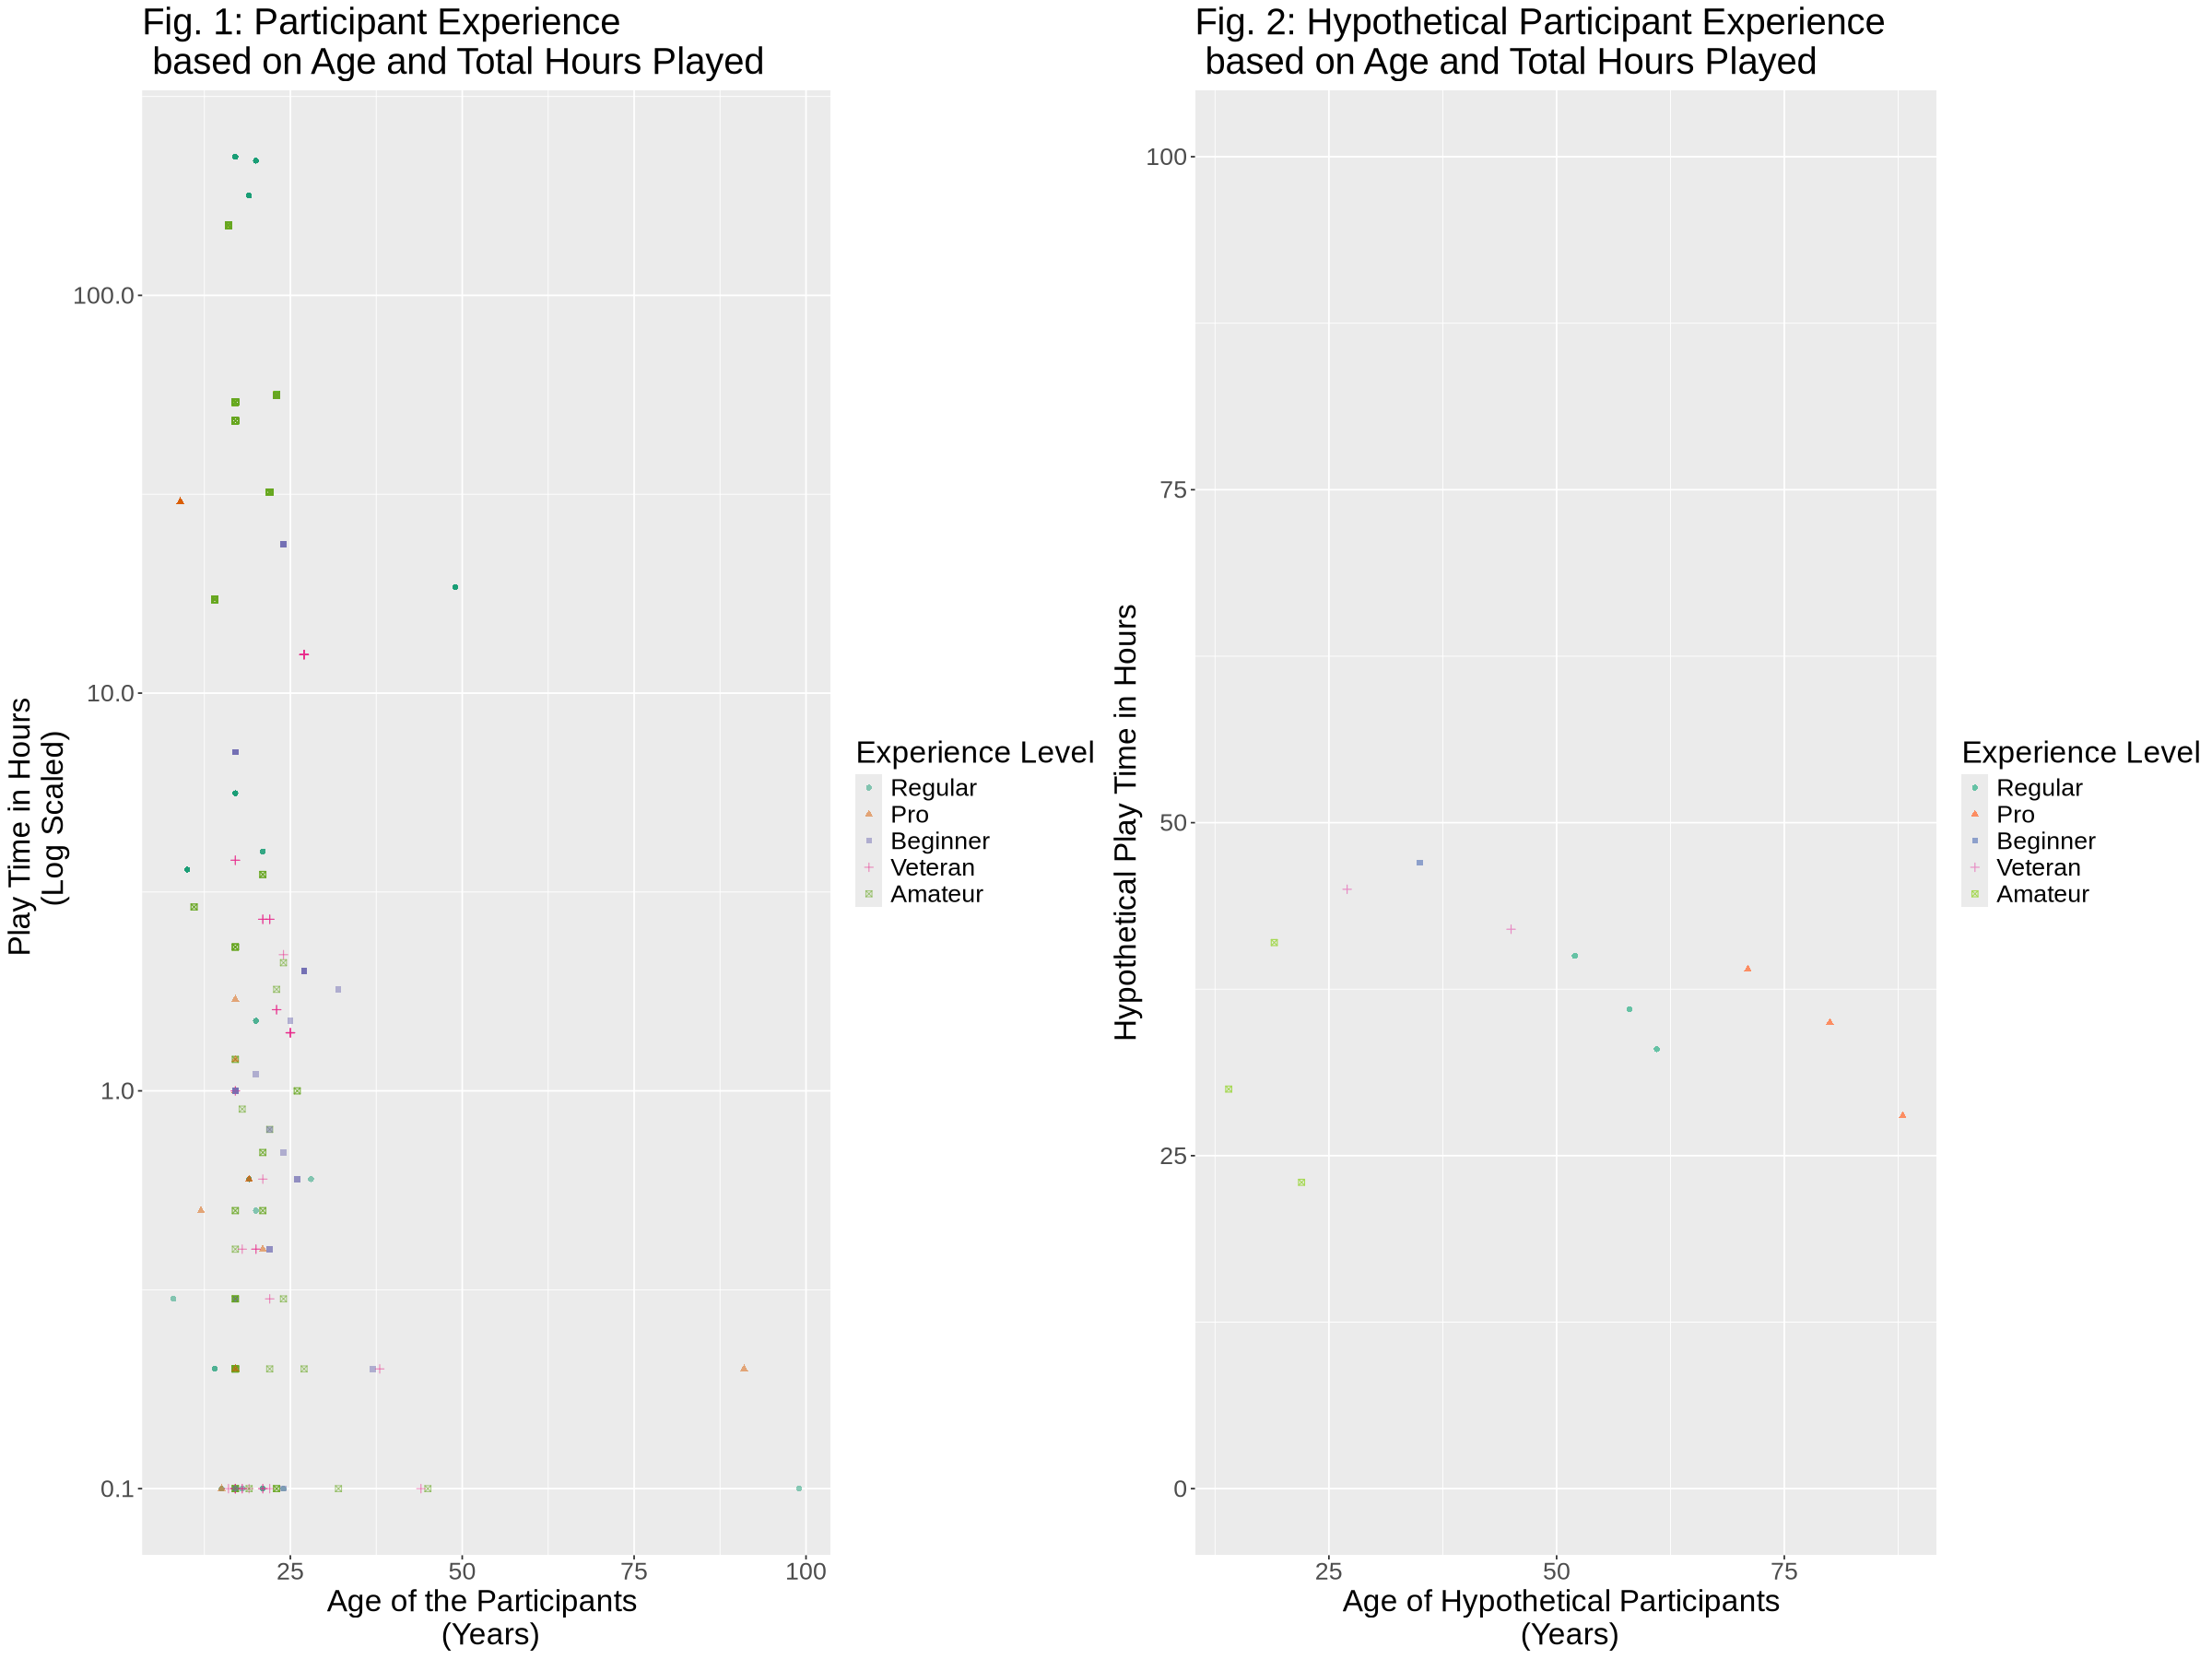

In [68]:
#Creating the columns for the new tibble data frame. (1)
age <- c (22, 35, 58, 45, 71, 14, 88, 61, 27, 52, 80, 19)
played_hours <- c (23, 47, 36, 42, 39, 30, 28, 33, 45, 40, 35, 41)

#Creating the data frame. (1)
hypo_people <- tibble (age, played_hours)

#Creating the recipe and fitting the model. (2)
final_recipe <- recipe (experience ~., data = playdate_final) |>
                step_scale (all_predictors()) |>
                step_center (all_predictors()) |>
                step_upsample (experience, over_ratio = 1, skip = TRUE)

#Renaming the model specification. (2)
final_model <- nearest_playdate

final_fit <- workflow() |>
            add_model (final_model) |>
            add_recipe (final_recipe) |>
            fit (data = playdate_final)


#Using the newly fit model and predicting the hypothetical peoples' experience level. (2)
hypo_predict <- predict (final_fit, hypo_people) |>
                bind_cols (hypo_people) 


#Creating the visualization. (3)
class_visualization <- hypo_predict |>
            ggplot (aes (x = age, y = played_hours, color = .pred_class, shape = .pred_class)) +
                geom_point () + 
                scale_color_brewer (palette = "Set2") +
                labs (x = "Age of Hypothetical Participants \n (Years)", y = "Hypothetical Play Time in Hours", title = "Fig. 2: Hypothetical Participant Experience \n based on Age and Total Hours Played", 
                      color = "Experience Level", shape = "Experience Level") + 
                ylim (0, 100.0) +
                theme (text = element_text (size = 20)) 

#This is just figure 1, but renamed to change text size
playdate_vision_text <- playdate_final |>
ggplot (aes(x = age, y = played_hours, color = experience, shape = experience)) +
geom_point(alpha = 0.5) +
scale_color_brewer (palette = "Dark2") +
labs (x = "Age of the Participants \n (Years)", y = "Play Time in Hours \n (Log Scaled)", title = "Fig. 1: Participant Experience \n based on Age and Total Hours Played"
      , color = "Experience Level", shape = "Experience Level") +
theme (text = element_text (size = 20)) +
scale_y_log10 ()

#Displaying the prediction plot (fig. 2) and the original plot (Fig. 1) side-by-side
grid.arrange (playdate_vision_text, class_visualization, ncol = 2)

#Changing plot size
options (repr.plot.length = 15, repr.plot.width = 20)

#Printing Prediction Results of Experience Classes of the hypo_people dataset.
print (hypo_predict)


## Discussion

Initially, we expected participants with high play hours to be veteran players who appeared to enjoy the game. We also predicted that people aged 12 to 18 would have the most playing hours because they have the most free time. After performing the classification model, our results show no correlation between the variables. An Increase or decrease in `played_hours` and `age` did not seem to have a direct effect on the level of experience. This does not align with our expectations. After further analysis of our results and our visualization, we realized there were no clear patterns in the plot; thus, age and playtime do not correlate and cannot be used to predict the best contributors. This could imply that other variables influence the amount of Minecraft data a participant contributes. Further research could collect additional demographics that could correlate with the player's interaction with the game. For example, what device players use, what other genre of games they enjoy, or their employment status. In addition, further information should be provided to explain the “types” of players because we assumed that the “type” meant experience. We suggest that, instead of experience, players should be classified by their in-game actions. An example of that could be builders, farmers, redstone experimenters, or players that like to play from beginning to end. This research impacts the efficiency of the main project. By knowing specifically which type of players to target for their research, they don’t have to spend as much resources on players that may not contribute as much data. Since the data is used to train AGI-like models, studying players who are most active in-game will provide better insight and materials to train the models.


## References

Plaicraft. PLAICraft. (n.d.). https://plaicraft.ai/ 

Smith, A. (2024, October 30). Plaicraft.ai launch. Pacific Laboratory for Artificial Intelligence. https://plai.cs.ubc.ca/2023/09/27/plaicraft/ 